In [1]:
from os import listdir
import pandas as pd
from datasets import Dataset
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, T5Tokenizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from rouge_score import rouge_scorer


C:\Users\andre\Desktop\data_boonedam\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Log solution data
directories = ["boon_edam_data/Data_ferdinand","boon_edam_data/Data_hasan","solutions"]

description_nlp = "Log solution.csv"
csv_files = []
for directory in directories:
    filenames = listdir(directory)
    for name in filenames:
        if name.endswith(".csv") and name == description_nlp:
            csv_files.append(directory+"/"+name)
print(csv_files)

['boon_edam_data/Data_ferdinand/Log solution.csv', 'boon_edam_data/Data_hasan/Log solution.csv', 'solutions/Log solution.csv']


In [3]:
# read Log solution file, append the monteur description and the short version description 
start_collect_event_log = False
original_descriptions = []
short_version_description = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file, encoding="utf-8", sep='delimiter', header=None, engine='python')
    for index, row in df.iterrows():
        if index != 0:
            for i in row:
                line = i.split(";")
                if line[1] and line[0]:
                    original_descriptions.append(line[1].lower())
                elif line[0] and not line[1]:
                    print("No original description for file",line[0])
                    print(line)
                if line[3] and line[0]:
                    short_version_description.append(line[3].lower())
                elif line[0] and not line[3]:
                    print("No summarized description for file",line[0])

In [4]:
# Datasplit in X_train en X_test
X_train, X_test, y_train, y_test = train_test_split(original_descriptions, short_version_description, test_size=0.2, random_state=42)

In [6]:
# Create a dictionary to organize the training data
sample_data = {
    'descriptions': X_train,
    'short_version_description': y_train
}

df = pd.DataFrame(sample_data)
dataset = Dataset.from_pandas(df)

In [7]:
# Initialize a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
# Fit the vectorizer on the 'descriptions' column and transform the text data into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['descriptions'])
# Convert the TF-IDF matrix to a pandas DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.columns)
columns = ['and','both','operational','device','open','showing','not']
print(tfidf_df.loc[9:15,columns])

Index(['and', 'be', 'become', 'both', 'contact', 'device', 'does', 'door',
       'failure', 'ghosting', 'indicated', 'is', 'lane', 'light', 'locking',
       'message', 'messages', 'needs', 'no', 'node', 'not', 'on', 'one',
       'open', 'operational', 'other', 'out', 'possible', 'red', 'reset',
       'showing', 'side', 'sides', 'signal', 'software', 'system', 'the', 'to',
       'update', 'work', 'working'],
      dtype='object')
         and      both  operational  device      open   showing       not
9   0.165604  0.201591          0.0     0.0  0.290168  0.185571  0.454439
10  0.165604  0.201591          0.0     0.0  0.290168  0.185571  0.454439
11  0.089338  0.000000          0.0     0.0  0.000000  0.000000  0.000000
12  0.215810  0.262707          0.0     0.0  0.000000  0.241831  0.000000
13  0.215810  0.262707          0.0     0.0  0.000000  0.241831  0.000000
14  0.215810  0.262707          0.0     0.0  0.000000  0.241831  0.000000
15  0.165604  0.201591          0.0     0.0 

Concept 0:
does 0.3780992443306358
not 0.3558933400076834
on 0.2653350397544225
both 0.26082829523112755
showing 0.2484326482911223
Concept 1:
message 0.3487514775408631
no 0.3468075564354399
side 0.3468075564354399
possible 0.32673712397225124
reset 0.3207164430087666
Concept 2:
working 0.5411505082454579
is 0.5355732936048596
lane 0.5355732936048596
showing 0.15737578111666412
not 0.13002550469698304
Concept 3:
light 0.39570451015843666
messages 0.39570451015843666
one 0.39570451015843666
other 0.39570451015843666
no 0.1822717737973615
Concept 4:
become 0.5629599442018777
device 0.5629599442018776
operational 0.5629599442018776
does 0.10671186400921331
not 0.09394001376401746


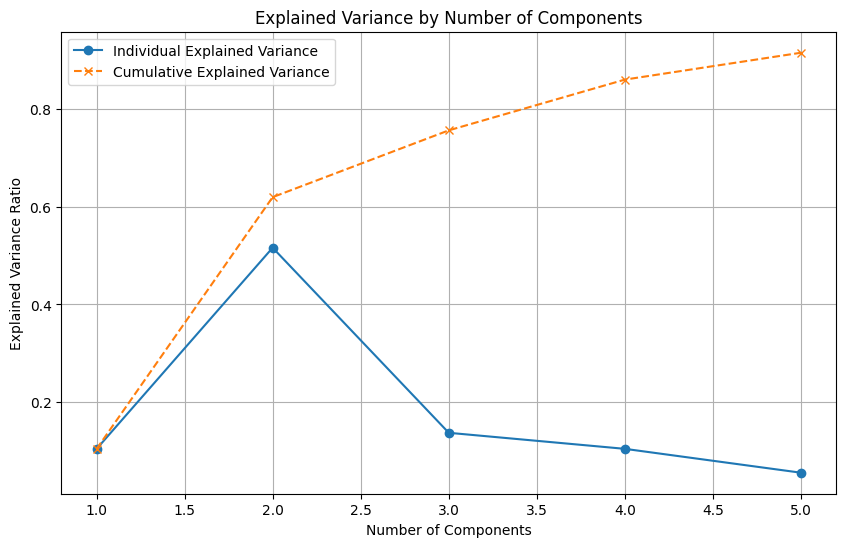

In [8]:
# Perform dimensionality reduction using Truncated SVD (Latent Semantic Analysis)
lsa = TruncatedSVD(n_components=5)
lsa_matrix = lsa.fit_transform(tfidf_matrix)
terms = tfidf_vectorizer.get_feature_names_out()

# Print the 5 highest correlated terms for each topic (component)
for i, comp in enumerate(lsa.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)
    print(f"Concept {i}:")
    for term in sorted_terms[:5]:
        print(term[0],term[1])

# Calculate the explained variance ratio for each component
explained_variance = lsa.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance ratio for each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='x', linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Number of Components')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Initialize the tokenizer for the T5 model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Define a preprocessing function for the dataset
def preprocess_function(data):
    # Tokenize the input descriptions with a maximum length of 512 tokens using padding and truncation to ensure uniform length
    inputs = ["summarize: " + doc for doc in data["descriptions"]]
    model_inputs = tokenizer(inputs, max_length=512, padding="max_length", truncation=True)

    # Tokenize the target summaries (short version descriptions) separately
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(data["short_version_description"], max_length=150, padding="max_length", truncation=True)

    # Add the tokenized labels to the model inputs
    model_inputs["labels"] = labels["input_ids"]
    # Replace padding token IDs in the labels with -100 to ignore them in the loss computation during training
    model_inputs["labels"] = [[label if label != tokenizer.pad_token_id else -100 for label in labels] for labels in model_inputs["labels"]]  # Ignore pad tokens in loss computation
    return model_inputs

# Preprocess the dataset by applying the preprocess function
tokenized_dataset = dataset.map(preprocess_function, batched=True)

C:\Users\andre\Desktop\data_boonedam\myenv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map:   0%|                                                                               | 0/61 [00:00<?, ? example

In [10]:
# Load the pre-trained T5 model for conditional generation
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Set up training arguments for fine-tuning the model
num = 20  # Number of training epochs
training_args = TrainingArguments(
    output_dir="./results",  # Directory to save model checkpoints and training results
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    learning_rate=1e-4,  # Learning rate for the optimizer
    per_device_train_batch_size=40,  # Batch size for training on each device (GPU/CPU)
    per_device_eval_batch_size=40,  # Batch size for evaluation on each device (GPU/CPU)
    num_train_epochs=num,  # Total number of training epochs
    weight_decay=0.01,  # Weight decay to apply for regularization
    logging_dir="./logs",  # Directory to store training logs
    logging_steps=1,  # Log training information after every step
    save_steps=20  # Save model checkpoints every 20 steps
)

# Initialize the Hugging Face Trainer for model training
trainer = Trainer(
    model=model,  # The model to be trained
    args=training_args,  # Training arguments defined above
    train_dataset=tokenized_dataset,  # The dataset to use for training
    eval_dataset=tokenized_dataset,  # The dataset to use for evaluation
    tokenizer=tokenizer,  # The tokenizer used for preprocessing the text
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained('./desription_model')
tokenizer.save_pretrained('./description_model')


Epoch,Training Loss,Validation Loss
1,2.627300,1.984042


KeyboardInterrupt: 

In [ ]:
# Initialize lists to store training and validation loss values
training_loss = []  # List to store the training loss for each epoch
validation_loss = []  # List to store the validation loss for each epoch
for i,log in enumerate(trainer.state.log_history):
  if 'loss' in trainer.state.log_history[i] and 'eval_loss' in trainer.state.log_history[i+1]:
    training_loss.append(trainer.state.log_history[i]['loss'])
    validation_loss.append(trainer.state.log_history[i+1]['eval_loss'])

epochs = list(range(1, len(training_loss) + 1))

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()